In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Error Analysis in Least Squares Regression

This notebook demonstrates how P-values are used for quick coefficient assessment in linear regression. I demonstrate the importance of the prior distribution.

## (1) Synthetic Linear Dataset with Noise

We generate a dataset that samples a hyperplane in N dimensions with a Gaussian distribution (noise) around it. A certain part of the coefficients will be zero, others not. Our goal is to find out which of the coefficients are *significant*.

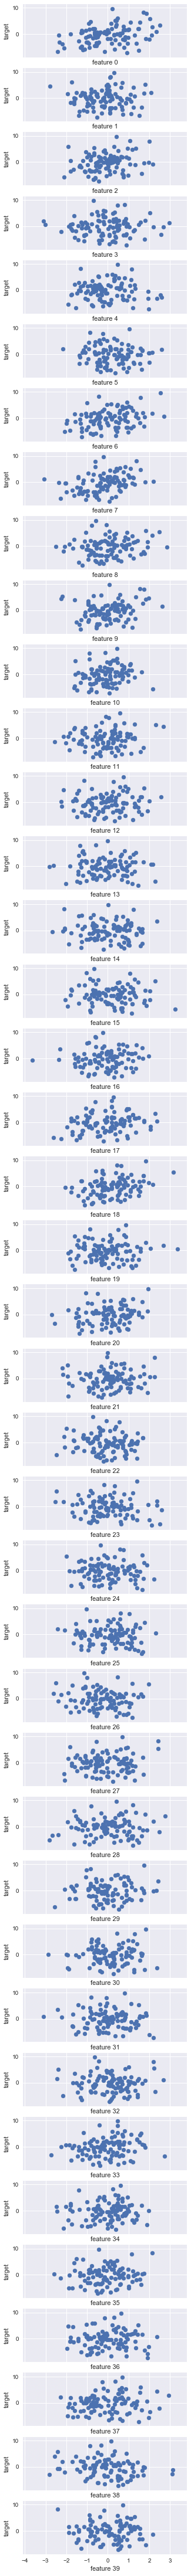

In [67]:
def get_dataset(n_points=50, n_features=2, n_null=1, noise_level=0.1):
    X = np.random.normal(loc=0, scale=1, size=(n_features * n_points))
    X = X.reshape(n_points, n_features)
    X_with_intercept = np.concatenate([np.ones(n_points)[:, None], X], axis=1)

    coeffs = np.ones(n_features + 1)
    icoeffs_null = np.random.choice(n_features + 1, n_null, replace=False)
    coeffs[icoeffs_null] = 0

    noise = np.random.normal(scale=noise_level, size=n_points)
    y = np.dot(coeffs, X_with_intercept.T) + noise
    return X_with_intercept, y

n_points = 100
n_features = 40
degrees_of_freedom = n_features + 1
null_fraction = 0.8
n_null = int(null_fraction * degrees_of_freedom)
noise_level = 2
X, y = get_dataset(n_points=n_points, n_features=n_features, n_null=n_null, noise_level=noise_level)

fig, axes = plt.subplots(n_features, 1, sharex=True, sharey=True,
                         figsize=(5, n_features*2))
for ifeature, feature in enumerate(X.T[1:]):
    ax = axes[ifeature]
    ax.scatter(feature, y)
    ax.set(xlabel='feature {}'.format(ifeature), ylabel='target')

## (2) Build a Least Squares Model

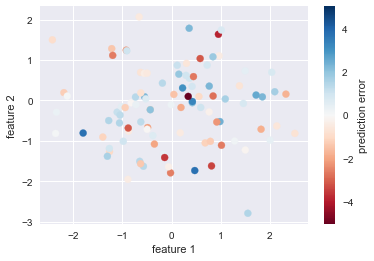

In [68]:
pseudo_inverse = np.dot(np.linalg.inv(np.dot(X.T, X)), X.T)
coeffs = np.dot(pseudo_inverse, y)

y_predicted = np.dot(coeffs, X.T)
error = y - y_predicted
std_empirical = np.sqrt(1/(n_points - degrees_of_freedom)*np.sum(error**2))

fig, ax = plt.subplots()
vrange = np.max(np.abs(error))
im = ax.scatter(X[:, 1], X[:, 2], c=error, vmin=-vrange, vmax=vrange, cmap='RdBu');
cb = plt.colorbar(im, label='prediction error')
ax.set(xlabel='feature 1', ylabel='feature 2');

## (3) Null Hypothesis and T-test without Prior

each coefficient is tested against the null-hypothesis, that it comes from a t distribution around zero.

In [69]:
from scipy.stats import t as t_distribution

coefficient_covariances = np.linalg.inv(np.dot(X.T, X))

x = np.linspace(-1.0, 1.5, 150)
dx = x[1] - x[0]

print('==== Z SCORES AND ONE SIDED P VALUES ====')
for icoeff in range(degrees_of_freedom):
    coefficient_covariance = coefficient_covariances[icoeff, icoeff]    
    scale = std_empirical * np.sqrt(coefficient_covariance)
    z_score = coeffs[icoeff]/scale
    p_value = 1 - t_distribution.cdf(np.abs(z_score), df=degrees_of_freedom, scale=1)
    print('coeffs[{:d}]={:2.2f}, z_score={:2.2f}, p_value={:2.2f}'.format(icoeff, coeffs[icoeff], z_score, p_value))

==== Z SCORES AND ONE SIDED P VALUES ====
coeffs[0]=-0.17, z_score=-0.60, p_value=0.27
coeffs[1]=1.24, z_score=4.78, p_value=0.00
coeffs[2]=-0.40, z_score=-1.29, p_value=0.10
coeffs[3]=1.05, z_score=3.20, p_value=0.00
coeffs[4]=-0.08, z_score=-0.30, p_value=0.38
coeffs[5]=-0.09, z_score=-0.30, p_value=0.38
coeffs[6]=0.04, z_score=0.15, p_value=0.44
coeffs[7]=0.97, z_score=3.51, p_value=0.00
coeffs[8]=1.08, z_score=3.77, p_value=0.00
coeffs[9]=0.24, z_score=0.87, p_value=0.20
coeffs[10]=1.03, z_score=3.09, p_value=0.00
coeffs[11]=0.47, z_score=1.21, p_value=0.12
coeffs[12]=0.12, z_score=0.36, p_value=0.36
coeffs[13]=0.46, z_score=1.68, p_value=0.05
coeffs[14]=-0.02, z_score=-0.06, p_value=0.48
coeffs[15]=-0.64, z_score=-2.27, p_value=0.01
coeffs[16]=-0.08, z_score=-0.29, p_value=0.39
coeffs[17]=-0.01, z_score=-0.03, p_value=0.49
coeffs[18]=0.97, z_score=3.16, p_value=0.00
coeffs[19]=0.68, z_score=2.40, p_value=0.01
coeffs[20]=0.27, z_score=0.91, p_value=0.18
coeffs[21]=0.83, z_score=2.5

### Illustration for a single coefficient

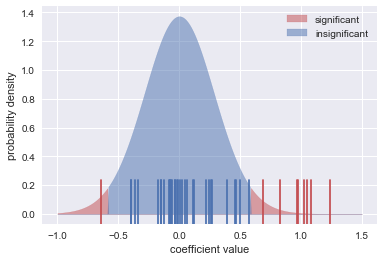

In [70]:
x = np.linspace(-1.0, 1.5, 300)
dx = x[1] - x[0]

icoeff = 5
coeff = coeffs[icoeff]
coefficient_covariance = coefficient_covariances[icoeff, icoeff]    
scale = std_empirical * np.sqrt(coefficient_covariance)
pdf_null = t_distribution.pdf(x, df=degrees_of_freedom, loc=0, scale=scale)
pdf_not_null = t_distribution.pdf(x, df=degrees_of_freedom, loc=1, scale=scale)
significance_null = t_distribution.interval(0.95, degrees_of_freedom, loc=0, scale=scale)
    
fig, ax = plt.subplots()
def is_signficant(x, signficance=significance_null):
    return (x < significance_null[0]) | (x > significance_null[1])

x_significant = is_signficant(x)
pdf_null_significant = np.copy(pdf_null)
pdf_null_significant[~x_significant] = 0

pdf_null_insignificant = np.copy(pdf_null)
pdf_null_insignificant[x_significant] = 0

ax.fill_between(x, pdf_null_significant, label='significant', color='C2', alpha=0.5)
ax.fill_between(x, pdf_null_insignificant, label='insignificant', color='C0', alpha=0.5)

for coeff in coeffs:
    if is_signficant(coeff):
        color='C2'
    else:
        color='C0'
    ax.axvline(x=coeff, ymin=0, ymax=0.2, c=color)
ax.legend()
ax.set(xlabel='coefficient value', ylabel='probability density');

We see in this plot, that it is difficult to distinguish coefficients that are zero from the significant ones. We now plot the theoretical distribution of significant and insignificant coefficients and we will see that it depends on the initial number of significant coefficients, which means that the p-value alone has no value ...

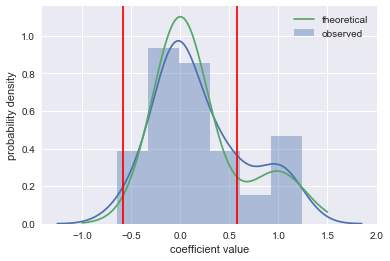

In [80]:
fig, ax = plt.subplots()
sns.distplot(coeffs, ax=ax, label='observed')
# ax.plot(x, pdf_null * null_fraction)
# ax.plot(x, pdf_not_null * (1 - null_fraction))
ax.plot(x, pdf_null * null_fraction + pdf_not_null * (1 - null_fraction), label='theoretical')
for vline in significance_null:
    ax.axvline(vline, ymin=0, ymax=1, c='red')
ax.legend()
ax.set(xlabel='coefficient value', ylabel='probability density');

What is the probability that one of the coefficients is significant? Well, the significance interval alone is not sufficient to answer this question. We need also the *ratio* of significant values in the whole dataset that determines the amplitude ratio of the distributions of null and non-null coefficients. This *null ratio is unknown* and corresponds to a Bayesian *prior* distribution, that reflects our believe in the dataset. A minimal prior could be, that only the coefficient that is tested for is significant, while all others are null.

## Minimal Assumption Prior

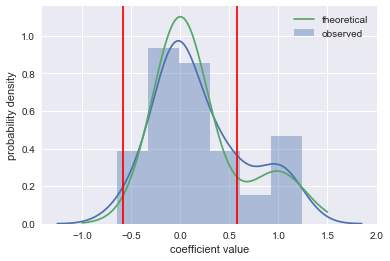

In [82]:
fig, ax = plt.subplots()
null_fraction_minimal = 1./degrees_of_freedom
sns.distplot(coeffs, ax=ax, label='observed')
# ax.plot(x, pdf_null * null_fraction)
# ax.plot(x, pdf_not_null * (1 - null_fraction))
ax.plot(x, pdf_null * null_fraction + pdf_not_null * (1 - null_fraction), label='theoretical')

coefficient_covariance = coefficient_covariances[icoeff, icoeff]    
scale = std_empirical * np.sqrt(coefficient_covariance)

wrong = 0.95 * 

quantile = 0.95 * null_ratio

significance_minimal = t_distribution.interval(0.95, degrees_of_freedom, loc=0, scale=scale)

for vline in significance_null:
    ax.axvline(vline, ymin=0, ymax=1, c='red')
ax.legend()
ax.set(xlabel='coefficient value', ylabel='probability density');